# identifying suspicious transactions

In this case study you are provided with a simple synthetic but realistic dataset of trades in csv format covering data from 2018/12 to 2020/01 and asked to perform analysis and a modelling task on it to predict if a trade is suspicious. A transaction could be classified as suspicious for different money laundering suspicion reasons. The description of the data variables is as below:

![explanation of data headers](img/data_dictionary.png)

Based on this dataset, you are required to develop a Machine learning solution to address the questions below using Python (this shouldn’t take you more than a few hours):
- Perform a basic exploratory analysis and describe the quality of the data
- Engineer a small number of features 
- Develop a machine learning solution to help identify future suspicious trades
- Provide an evaluation of your model, explain what metrics you have used, what parameters are used by your model, and any limitations you can think of.
- Do best attempts at building a clean data pipeline providing the basis for production code
- Demonstrate using logging to help debugging in the future
- Build at least one unit-test and one validation-test.
We’re not expecting you to write production ready solution in a few hours, but we care about your adopting programming best practices as much as about a sound data science methodology. Make clear which areas of concern in your solution would need to be improved.
Please send your code/notebook with any visualisation and results you have produced within 7 days after you received this email. Please message michael.heusch@santander.co.uk or max.palmer@santander.co.uk if you need clarification on any of the above and to submit your final solution.

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from employee import motivation_to_work

from src.eda import check_for_nulls
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
# from tqdm import tqdm_notebook
%matplotlib inline  
plt.rcParams['font.size'] = 16.0
plt.rcParams['figure.figsize'] = (17.0, 6.0)

In [2]:
transactions = pd.read_csv('data/raw/suspicious_transactions_dataset_201812-202001.csv')

In [3]:
print(transactions.shape)
display(transactions.head(3))
display(transactions.sample(5))
display(transactions.tail(3))

(30477, 13)


,Source System,Leg Type,Trade Date,Product Name,Product Group,Notional Amount Currency,CountryCodeOffice,ML Risk Rating,Client Name,Notional Amount,Gbp Notional Amount,Fx_rate,Flag
0,alpha,CASH,03/12/2018,FX Options,FX DERIV,USD,GB,M,Client_43,202800.0,1.707783e+05,0.842102,0
1,alpha,CASH,03/12/2018,FX Spots,FX TRADES,HKD,GB,L,Client_29,31570000.0,3.128810e+06,0.099107,0
2,alpha,CASH,03/12/2018,FX Forwards,FX TRADES,EUR,GB,M,Client_42,917400.0,8.186487e+05,0.892357,0


,Source System,Leg Type,Trade Date,Product Name,Product Group,Notional Amount Currency,CountryCodeOffice,ML Risk Rating,Client Name,Notional Amount,Gbp Notional Amount,Fx_rate,Flag
12711,alpha,CASH,22/05/2019,FX Options,FX DERIV,USD,GB,M,Client_146,330000.0000,264150.94720,0.800457,0
14630,alpha,CASH,25/06/2019,FX Spots,FX TRADES,EUR,GB,M,Client_512,211.5600,205.76800,0.972622,0
7221,alpha,CASH,20/02/2019,FX Spots,FX TRADES,USD,GB,H,Client_20,5225.9338,4352.57170,0.832879,0
1540,alpha,CASH,14/12/2018,FX Spots,FX TRADES,EUR,GB,L,Client_11,3309.0000,2910.59082,0.879598,0
27782,alpha,CASH,18/12/2019,FX Spots,FX TRADES,USD,GB,H,Client_158,259395.8375,205689.97350,0.792958,0


,Source System,Leg Type,Trade Date,Product Name,Product Group,Notional Amount Currency,CountryCodeOffice,ML Risk Rating,Client Name,Notional Amount,Gbp Notional Amount,Fx_rate,Flag
30474,alpha,CASH,31/01/2020,FX NDFs,FX TRADES,USD,GB,L,Client_305,7.690059e+06,5.972256e+06,0.776620,0
30475,alpha,CASH,31/01/2020,FX Forwards,FX TRADES,EUR,GB,M,Client_392,1.283198e+04,1.104125e+04,0.860448,0
30476,beta,CASH,31/01/2020,FX Swaps,FX TRADES,EUR,FR,H,Client_514,2.200000e+08,1.892985e+08,0.860448,0


In [29]:
display(transactions.describe())

,Notional Amount,Gbp Notional Amount,Fx_rate,Flag,month,weekday,quarter
count,3.047700e+04,3.047700e+04,30473.000000,30477.000000,30477.000000,30477.000000,30477.000000
mean,4.546846e+07,1.336486e+07,0.749123,0.005644,6.908816,1.992683,2.619516
std,1.041652e+09,7.100275e+07,0.228411,0.074913,4.013045,1.399184,1.222652
min,0.000000e+00,0.000000e+00,0.002769,0.000000,1.000000,0.000000,1.000000
25%,1.283198e+04,8.619836e+03,0.762732,0.000000,3.000000,1.000000,1.000000
50%,6.250000e+04,4.367871e+04,0.816337,0.000000,7.000000,2.000000,3.000000
75%,3.179440e+05,2.145183e+05,0.869434,0.000000,11.000000,3.000000,4.000000
max,7.170755e+10,2.045535e+09,1.016312,1.000000,12.000000,4.000000,4.000000


In [28]:
display(transactions.describe(include=['object']))

,Source System,Leg Type,Trade Date,Product Name,Product Group,Notional Amount Currency,CountryCodeOffice,ML Risk Rating,Client Name
count,30374,30447,30477,30412,30476,30477,30477,30455,30477
unique,3,1,299,10,6,26,16,3,532
top,alpha,CASH,12/12/2019,FX Spots,FX TRADES,USD,GB,L,Client_20
freq,27966,30447,260,20412,29536,13529,28267,12128,4554


In [5]:
columns_with_nulls = check_for_nulls(transactions)

checking for nulls in Index(['Source System', 'Leg Type', 'Trade Date', 'Product Name',
       'Product Group', 'Notional Amount Currency', 'CountryCodeOffice',
       'ML Risk Rating', 'Client Name', 'Notional Amount',
       'Gbp Notional Amount', 'Fx_rate', 'Flag'],
      dtype='object')
column Source System contains 103 null values
column Leg Type contains 30 null values
column Product Name contains 65 null values
column Product Group contains 134 null values
column ML Risk Rating contains 22 null values
column Fx_rate contains 4 null values


In [6]:
print(sum(transactions['Flag']), 'records flagged as suspicious')

172 records flagged as suspicious


In [7]:
categorical_fields = [
    'Source System',
    'Leg Type',
    'Product Name',
    'Product Group',
    'Notional Amount Currency',
    'CountryCodeOffice',
    'ML Risk Rating',
    'Flag'
]

for column in categorical_fields:
    print('-'*50, column, 'distribution','-'*50,)
    print(transactions[column].value_counts(dropna=False))
    display(pd.crosstab(transactions[column], transactions['Flag'], dropna=False, margins=True))

-------------------------------------------------- Source System distribution --------------------------------------------------
alpha    27966
beta      2392
NaN        103
gamma       16
Name: Source System, dtype: int64


Flag,0,1,All
Source System,,,
alpha,27898,68,27966
beta,2289,103,2392
gamma,16,0,16
All,30305,172,30477


-------------------------------------------------- Leg Type distribution --------------------------------------------------
CASH    30447
NaN        30
Name: Leg Type, dtype: int64


Flag,0,1,All
Leg Type,,,
CASH,30276,171,30447
All,30305,172,30477


-------------------------------------------------- Product Name distribution --------------------------------------------------
FX Spots                20412
FX Forwards              4891
FX Swaps                 4031
FX Options                550
IRS-ON Index Swap         186
IRS-Vanilla               177
FX NDFs                   139
NaN                        65
Deal Related Payment       16
CRS-Vanilla                 6
Swaptions                   4
Name: Product Name, dtype: int64


Flag,0,1,All
Product Name,,,
CRS-Vanilla,6,0,6
Deal Related Payment,16,0,16
FX Forwards,4891,0,4891
FX NDFs,139,0,139
FX Options,550,0,550
FX Spots,20345,67,20412
FX Swaps,3931,100,4031
IRS-ON Index Swap,183,3,186
IRS-Vanilla,177,0,177


-------------------------------------------------- Product Group distribution --------------------------------------------------
FX TRADES                 29406
FX DERIV                    549
IRS                         362
NaN                         134
Miscellaneous Payments       16
CIRS                          6
Swaption                      4
Name: Product Group, dtype: int64


Flag,0,1,All
Product Group,,,
CIRS,6,0,6
FX DERIV,549,0,549
FX TRADES,29238,168,29406
IRS,359,3,362
Miscellaneous Payments,16,0,16
Swaption,4,0,4
All,30305,172,30477


-------------------------------------------------- Notional Amount Currency distribution --------------------------------------------------
USD    13529
EUR    12098
AED     1013
AUD      669
CAD      495
JPY      396
PLN      366
ZAR      262
SEK      218
NZD      205
CHF      203
THB      193
NOK      189
DKK      137
HKD      117
SGD      117
INR       98
CNH       73
MXN       27
ILS       27
CZK       23
TRY       10
BRL        6
HUF        2
MAD        2
RUB        2
Name: Notional Amount Currency, dtype: int64


Flag,0,1,All
Notional Amount Currency,,,
AED,1005,8,1013
AUD,666,3,669
BRL,6,0,6
CAD,493,2,495
CHF,203,0,203
CNH,73,0,73
CZK,23,0,23
DKK,136,1,137
EUR,12056,42,12098


-------------------------------------------------- CountryCodeOffice distribution --------------------------------------------------
GB    28267
CH     1195
IM      255
DK      216
FR      150
NL      149
CA       85
IE       65
AU       28
FI       21
GG       16
LU        9
JE        7
US        7
CY        6
ES        1
Name: CountryCodeOffice, dtype: int64


Flag,0,1,All
CountryCodeOffice,,,
AU,28,0,28
CA,51,34,85
CH,1171,24,1195
CY,6,0,6
DK,216,0,216
ES,1,0,1
FI,21,0,21
FR,134,16,150
GB,28169,98,28267


-------------------------------------------------- ML Risk Rating distribution --------------------------------------------------
L      12128
M       9805
H       8522
NaN       22
Name: ML Risk Rating, dtype: int64


Flag,0,1,All
ML Risk Rating,,,
H,8454,68,8522
L,12061,67,12128
M,9768,37,9805
All,30305,172,30477


-------------------------------------------------- Flag distribution --------------------------------------------------
0    30305
1      172
Name: Flag, dtype: int64


Flag,0,1,All
Flag,,,
0,30305,0,30305
1,0,172,172
All,30305,172,30477


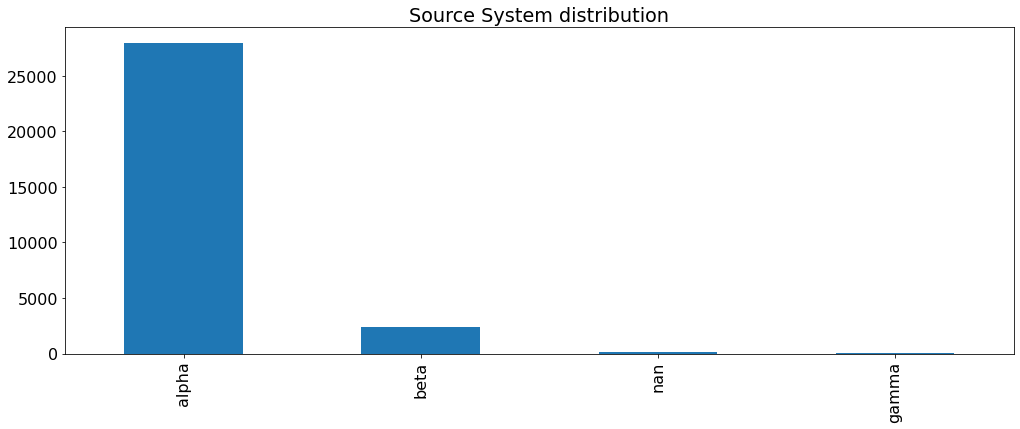

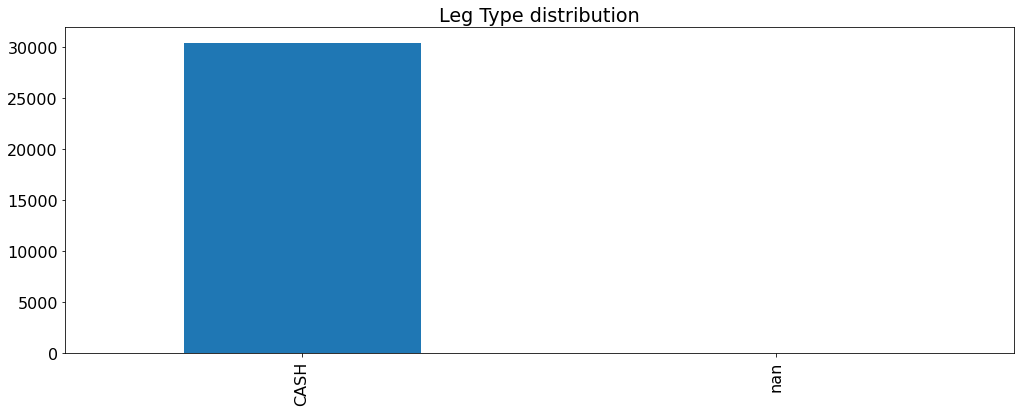

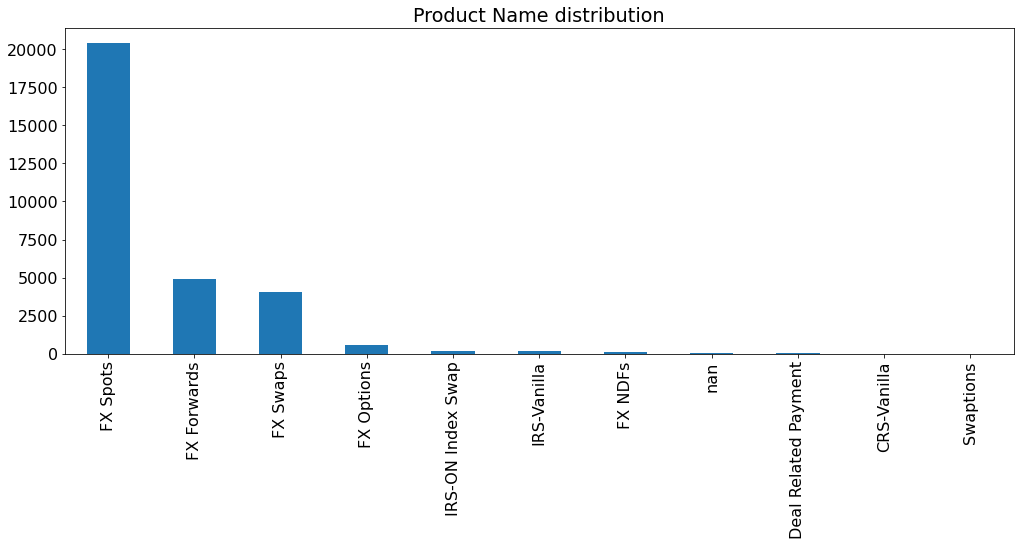

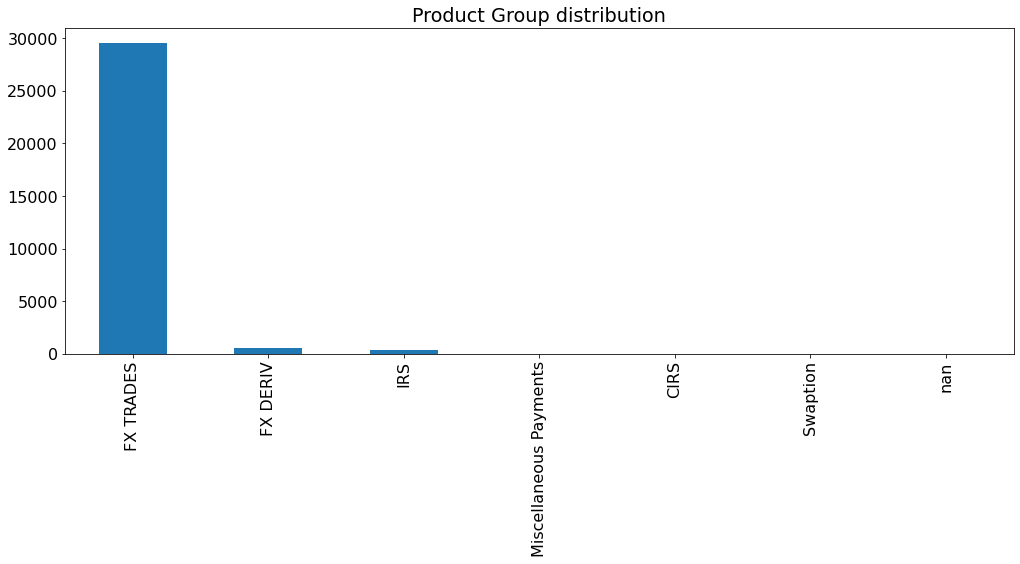

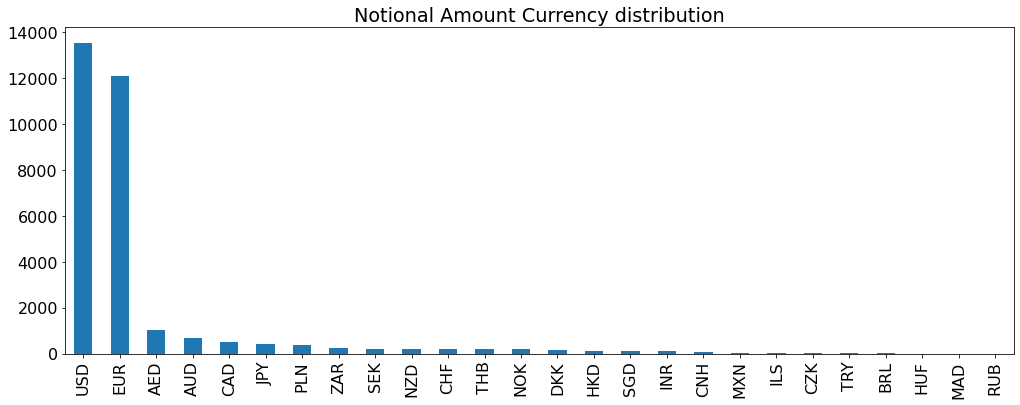

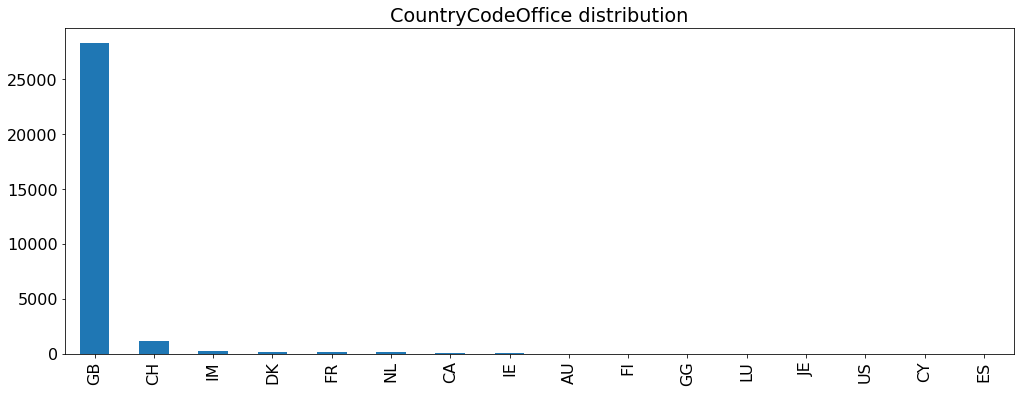

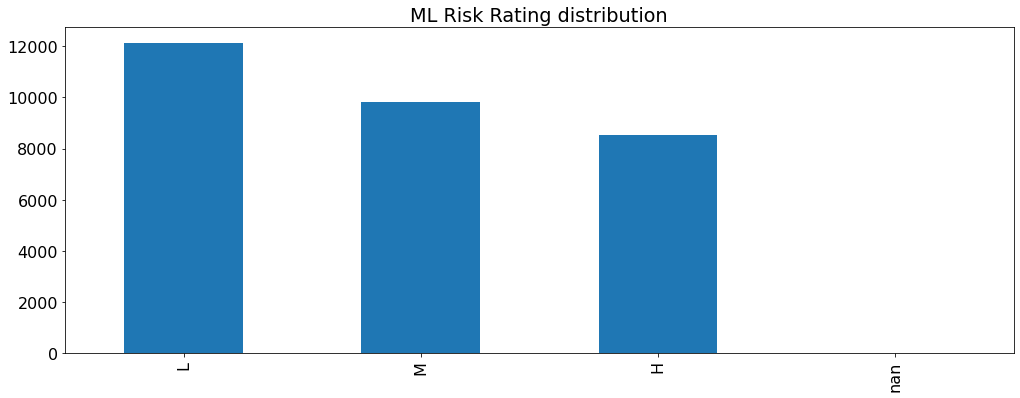

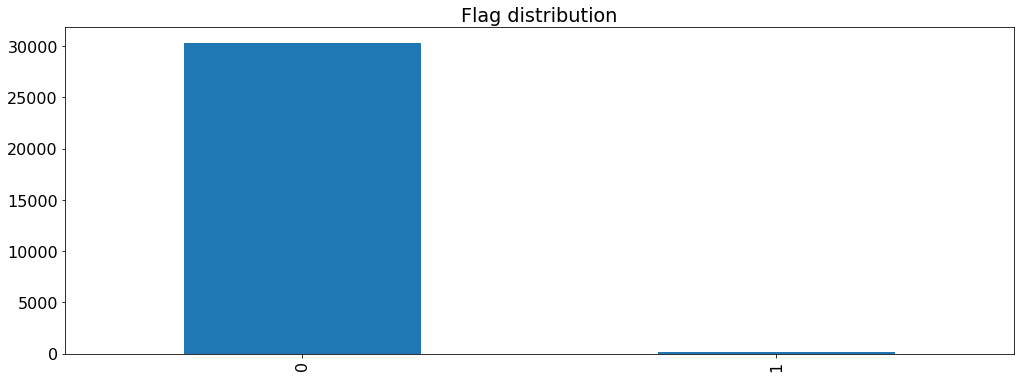

In [31]:
for column in categorical_fields:
    transactions[column]\
        .value_counts(dropna=False)\
        .plot\
        .bar(title=column+' distribution')
    plt.savefig('plots/eda/distribution_'+column+'.png')
    plt.show()

In [9]:
flagged_transactions = transactions[transactions['Flag']==1]
flagged_transactions.shape

(172, 13)

## some early observations:
- highly imbalanced data set: 30k records, of which only 172 (0.6%) are flagged as suspicious. 
- each record has 13 fields, including the suspicious flag.
- most of the 12 feature fields are unevenly distributed (excpetion: ml risk score).
- a much higher proportion of transactions with `Source System = "beta"` are flagged suspicious than `Source System = "alpha"` or `Source System = "gamma"`
- `Leg Type` is useless.
- the two products, `FX Swaps` and `FX Spots` are responsible for the bulk of suspicious transactions, with a relatively high proportion of the former being flagged. both belong to the `FX TRADES` product group. 
- 134 rows lack `Product Group` information, which may be recoverable.
- high relative frequency of suspicious transactions in indian rupees and japanese yen (ca 5%), also, to lesser extent, usd (~<1%). 
- the canadian office `CA` , has a high relative rate of flagged transactions (40%, albeit low counts). to lesser extent, so do the french office, `FR` (10%) and the swiss office, `CH`, as well (~2%).  
- a "high" `ML Risk Rating` implies higher relative rate of being flagged suspicious. but little difference between medium and low risk rating.
- 345 records have missing values in at least one field. however, may be possible to impute some of the missing values. if these are removed completely the number of flagged records flagged drops to 168. 


## clean/adjust data set
- drop useless columns
- impute missing values where possible
### product name -> product group
- note that `column Product Group contains 134 null values`
- expect that the product group can be imputed given the product name.
- first verify the uniqueness of the  product `name->group` relationship. 

In [10]:
pd.crosstab(transactions['Product Name'], transactions['Product Group'], dropna=False)

Product Group,CIRS,FX DERIV,FX TRADES,IRS,Miscellaneous Payments,Swaption
Product Name,,,,,,
CRS-Vanilla,6,0,0,0,0,0
Deal Related Payment,0,0,0,0,16,0
FX Forwards,0,0,4875,0,0,0
FX NDFs,0,0,139,0,0,0
FX Options,0,548,0,0,0,0
FX Spots,0,0,20309,0,0,0
FX Swaps,0,0,4020,0,0,0
IRS-ON Index Swap,0,0,0,185,0,0
IRS-Vanilla,0,0,0,177,0,0


In [32]:
product_name_to_product_type = \
{
    'CRS-Vanilla'          : 'other',
    'Deal Related Payment' : 'other',
    'FX Forwards'          : 'fx_forwards',
    'FX NDFs'              : 'fx_other',    
    'FX Options'           : 'fx_other',
    'FX Spots'             : 'fx_spots',
    'FX Swaps'             : 'fx_swaps',
    'IRS-ON Index Swap'    : 'irs',
    'IRS-Vanilla'          : 'irs',
    'Swaptions'            : 'other',
}
temp_df = pd.DataFrame({'product_name':product_name_to_product_type.keys(), 
                        'product_type': product_name_to_product_type.values()})
# view
pd.merge(transactions, temp_df, left_on='Product Name', right_on='product_name', how='left')\
    .drop(columns=['Product Name', 'Product Group'])\
    .sample(30)

,Source System,Leg Type,Trade Date,Notional Amount Currency,CountryCodeOffice,ML Risk Rating,Client Name,Notional Amount,Gbp Notional Amount,Fx_rate,Flag,date,month,is_month_start,is_month_end,weekday,quarter,product_name,product_type
0,alpha,CASH,03/12/2018,USD,GB,M,Client_43,2.028000e+05,1.707783e+05,0.842102,0,2018-12-03,12,False,False,0,4,FX Options,fx_other
1,alpha,CASH,03/12/2018,HKD,GB,L,Client_29,3.157000e+07,3.128810e+06,0.099107,0,2018-12-03,12,False,False,0,4,FX Spots,fx_spots
2,alpha,CASH,03/12/2018,EUR,GB,M,Client_42,9.174000e+05,8.186487e+05,0.892357,0,2018-12-03,12,False,False,0,4,FX Forwards,fx_forwards
3,alpha,CASH,03/12/2018,USD,GB,L,Client_51,8.580000e+04,7.225234e+04,0.842102,0,2018-12-03,12,False,False,0,4,FX Forwards,fx_forwards
4,alpha,CASH,03/12/2018,USD,GB,M,Client_51,1.100000e+05,8.554188e+04,0.777653,0,2018-12-03,12,False,False,0,4,FX Forwards,fx_forwards
5,alpha,CASH,03/12/2018,USD,GB,M,Client_51,1.070000e+05,7.866798e+04,0.735215,0,2018-12-03,12,False,False,0,4,FX Forwards,fx_forwards
6,alpha,CASH,03/12/2018,JPY,GB,L,Client_4,6.573975e+06,4.543342e+04,0.006911,0,2018-12-03,12,False,False,0,4,FX Spots,fx_spots
7,alpha,CASH,03/12/2018,JPY,GB,H,Client_18,3.920400e+06,2.785737e+04,0.007106,0,2018-12-03,12,False,False,0,4,FX Spots,fx_spots
8,alpha,CASH,03/12/2018,EUR,GB,L,Client_104,2.500000e+05,2.155999e+05,0.862400,0,2018-12-03,12,False,False,0,4,FX Swaps,fx_swaps
9,alpha,CASH,03/12/2018,EUR,GB,L,Client_104,4.412000e+05,3.880799e+05,0.879601,0,2018-12-03,12,False,False,0,4,FX Swaps,fx_swaps


## convert dates 
what the date of a trade tell us about likelihood of fraud?


In [12]:
transactions['date'] = pd.to_datetime(transactions['Trade Date'], format='%d/%m/%Y')
print('there are', sum(transactions['date'].isnull()), 'nonsensical date strings')
display(transactions['Trade Date'].describe())
display(transactions['date'].describe(datetime_is_numeric=True))
transactions['month'] = transactions['date'].dt.month
transactions['is_month_start'] = transactions['date'].dt.is_month_start
transactions['is_month_end'] = transactions['date'].dt.is_month_end
transactions['weekday'] = transactions['date'].dt.weekday
transactions['quarter'] = transactions['date'].dt.quarter
display(pd.crosstab(transactions['quarter'], [transactions['Flag'],], margins=True, dropna=False,))
display(pd.crosstab(transactions['month'],   [transactions['Flag'],], margins=True, dropna=False,))
display(pd.crosstab(transactions['weekday'], [transactions['Flag'],], margins=True, dropna=False,))
display(pd.crosstab(transactions['is_month_end'], [transactions['Flag'],], margins=True, dropna=False,))
display(pd.crosstab(transactions['is_month_start'], [transactions['Flag'],], margins=True, dropna=False,))

there are 0 nonsensical date strings


count          30477
unique           299
top       12/12/2019
freq             260
Name: Trade Date, dtype: object

count                            30477
mean     2019-06-28 02:44:11.363323392
min                2018-12-03 00:00:00
25%                2019-02-26 00:00:00
50%                2019-07-04 00:00:00
75%                2019-10-22 00:00:00
max                2020-01-31 00:00:00
Name: date, dtype: object

Flag,0,1,All
quarter,,,
1,8504,69,8573
2,5058,6,5064
3,6209,17,6226
4,10534,80,10614
All,30305,172,30477


Flag,0,1,All
month,,,
1,4324,63,4387
2,2342,5,2347
3,1838,1,1839
4,1644,2,1646
5,1834,2,1836
6,1580,2,1582
7,2033,10,2043
8,1935,3,1938
9,2241,4,2245


Flag,0,1,All
weekday,,,
0,6033,26,6059
1,5953,35,5988
2,6298,28,6326
3,6293,32,6325
4,5728,51,5779
All,30305,172,30477


Flag,0,1,All
is_month_end,,,
False,29349,171,29520
True,956,1,957
All,30305,172,30477


Flag,0,1,All
is_month_start,,,
False,29550,172,29722
True,755,0,755
All,30305,172,30477


In [13]:
num_transactions_per_date = transactions['date'].value_counts().sort_index()
print(num_transactions_per_date.index[0],
      num_transactions_per_date.index[-1], 
      num_transactions_per_date.index[-1]-num_transactions_per_date.index[0], 
      len(num_transactions_per_date))

2018-12-03 00:00:00 2020-01-31 00:00:00 424 days 00:00:00 299


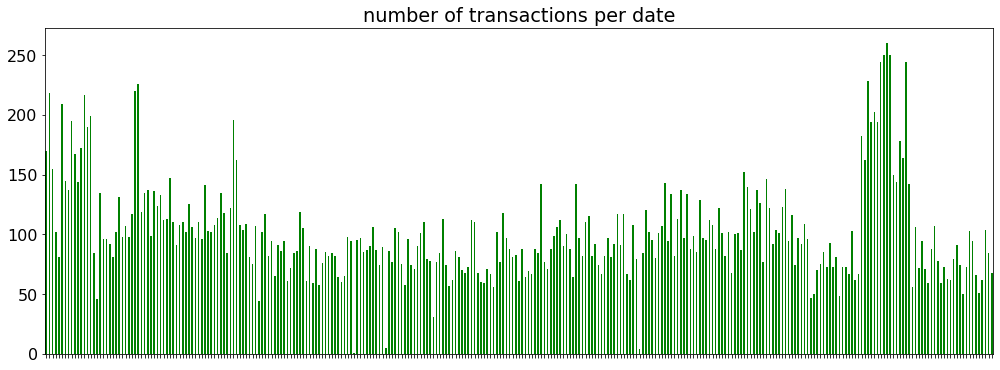

In [14]:
ax = num_transactions_per_date.plot.bar(title='number of transactions per date',color='green')
# num_flagged_per_date.plot.bar(title='number of transactions per date',color='red')
ax.set_xticklabels(list(str('') * len(transactions['date'])))
plt.show()

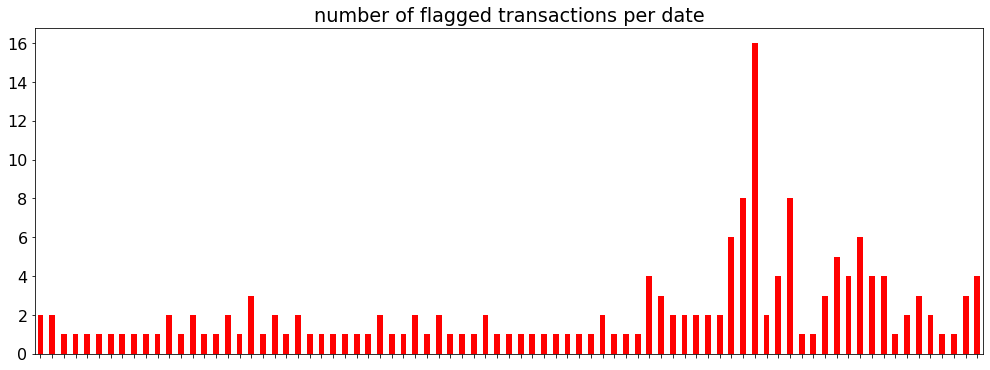

In [33]:
num_flagged_per_date = transactions[transactions['Flag']==1]['date'].value_counts( ).sort_index()
ax = num_flagged_per_date.plot.bar(title='number of flagged transactions per date',color='red')
ax.set_xticklabels(list(str('') * len(transactions['date'])))
plt.show()

## observations from the trade dates
- 299 distinct trade dates, out of 424 distinct dates in the time span of the data. (125 dates have no transactions).
- all trade dates are during the work week. i assume other missing dates are weekends and bank holidays etc.
- the second quarter has (suspiciously!?) few suspicious trades labelled. implying a quiet period in fraud or blind spot in flagging. to a lesser extent so does the 3rd quarter too
- there are about 100 trades per day
- for a long period the rate of suspicous/flagged transactions hovered around 2, but lately is higher and oscillates around 4
- december/january (months 12 and 1) have more suspicious trades, both in raw counts and relative to total frequencies of trades.
- fridays (weekday 4) have more flagged trades, both in raw counts and relative to total frequencies of trades.

In [16]:
# verify relationship between notional amounts with a test
test_bool = np.abs(transactions['Notional Amount'] * transactions['Fx_rate'] 
                   - transactions['Gbp Notional Amount'])\
            /transactions['Gbp Notional Amount'] < 0.001
sum(test_bool) 
# all (save for four) records pass. 

30473

In [17]:
# explore missing values in amount field:
print('gbp amount has', sum(transactions['Gbp Notional Amount'].isnull()), 'missing values')
# no missing values. 
display(transactions['Gbp Notional Amount'].describe())
# contains zero values. explore records with (near) zero values:
sum(transactions['Gbp Notional Amount']<0.5)
# only 13 records. view all suspiciously low amount records:
transactions[transactions['Gbp Notional Amount']<0.5]
transactions[transactions['Notional Amount']<0.5]
# will need to drop all missing or zero amount records. maybe flag all as suspicious?
# transactions['todrop'] = transactions[transactions['Gbp Notional Amount']<0.5]
# display(transactions[transactions['Gbp Notional Amount'].isnull()])
# display(transactions['Gbp Notional Amount'].describe())
# display(transactions[transactions['Gbp Notional Amount']==0])

gbp amount has 0 missing values


count    3.047700e+04
mean     1.336486e+07
std      7.100275e+07
min      0.000000e+00
25%      8.619836e+03
50%      4.367871e+04
75%      2.145183e+05
max      2.045535e+09
Name: Gbp Notional Amount, dtype: float64

,Source System,Leg Type,Trade Date,Product Name,Product Group,Notional Amount Currency,CountryCodeOffice,ML Risk Rating,Client Name,Notional Amount,Gbp Notional Amount,Fx_rate,Flag,date,month,is_month_start,is_month_end,weekday,quarter
393,alpha,CASH,05/12/2018,FX Forwards,FX TRADES,EUR,GB,H,Client_24,0.0,0.0,NaN,0,2018-12-05,12,False,False,2,4
4242,alpha,CASH,16/01/2019,FX Forwards,FX TRADES,EUR,GB,M,Client_24,0.0,0.0,NaN,0,2019-01-16,1,False,False,2,1
4996,alpha,CASH,24/01/2019,FX Forwards,FX TRADES,USD,GB,H,Client_24,0.0,0.0,NaN,0,2019-01-24,1,False,False,3,1
4997,alpha,CASH,24/01/2019,FX Forwards,FX TRADES,USD,GB,M,Client_24,0.0,0.0,NaN,0,2019-01-24,1,False,False,3,1


In [18]:
transactions[transactions['Notional Amount']<0.5]

,Source System,Leg Type,Trade Date,Product Name,Product Group,Notional Amount Currency,CountryCodeOffice,ML Risk Rating,Client Name,Notional Amount,Gbp Notional Amount,Fx_rate,Flag,date,month,is_month_start,is_month_end,weekday,quarter
393,alpha,CASH,05/12/2018,FX Forwards,FX TRADES,EUR,GB,H,Client_24,0.0,0.0,NaN,0,2018-12-05,12,False,False,2,4
4242,alpha,CASH,16/01/2019,FX Forwards,FX TRADES,EUR,GB,M,Client_24,0.0,0.0,NaN,0,2019-01-16,1,False,False,2,1
4996,alpha,CASH,24/01/2019,FX Forwards,FX TRADES,USD,GB,H,Client_24,0.0,0.0,NaN,0,2019-01-24,1,False,False,3,1
4997,alpha,CASH,24/01/2019,FX Forwards,FX TRADES,USD,GB,M,Client_24,0.0,0.0,NaN,0,2019-01-24,1,False,False,3,1


## notes on amounts
- four trade records had no amount information. these also lack currency rate information.
- can drop `Notional Amount` and `FX_rate`. only their multiple, gbp amount is comparable across records.
- log (gbp) amount is approximately lognormal




# cleaning: impute null values or drop records 
## product name -> product group

we saw earlier that there are 345 records that have at least 1 missing value. a large number of these lack the product group, which can be imputed from the product name.

we note that
```
column Product Group contains 134 null values
```
it is reasonable to expect that the product group can be imputed given the product name. we first verify the uniqueness of the  product `name->group` relationship. given that each product belongs to one and only one group, i feel confident i can impute missing group names given the product name.

In [19]:
pd.crosstab(transactions['Product Name'], transactions['Product Group'], dropna=False)
# for group in transactions['Product Group'].dropna(axis=0).unique():
#     print('-------', group, '--------')
#     print(transactions[transactions['Product Group'] == group]['Product Name'].value_counts())
# print('*'*50)
# for product in transactions['Product Name'].dropna(axis=0).unique():
#     print('-------', product, '--------')
#     print(transactions[transactions['Product Name'] == product]['Product Group'].value_counts())

Product Group,CIRS,FX DERIV,FX TRADES,IRS,Miscellaneous Payments,Swaption
Product Name,,,,,,
CRS-Vanilla,6,0,0,0,0,0
Deal Related Payment,0,0,0,0,16,0
FX Forwards,0,0,4875,0,0,0
FX NDFs,0,0,139,0,0,0
FX Options,0,548,0,0,0,0
FX Spots,0,0,20309,0,0,0
FX Swaps,0,0,4020,0,0,0
IRS-ON Index Swap,0,0,0,185,0,0
IRS-Vanilla,0,0,0,177,0,0


In [20]:
prod_name_to_group = {
    'FX Options'           : 'FX DERIV',
    'FX Spots'             : 'FX TRADES',
    'FX Forwards'          : 'FX TRADES',
    'FX Swaps'             : 'FX TRADES',
    'IRS-ON Index Swap'    : 'IRS',
    'IRS-Vanilla'          : 'IRS',
    'Deal Related Payment' : 'Miscellaneous Payments',
    'FX NDFs'              : 'FX TRADES',    
    'Swaptions'            : 'Swaptions',
}
for key in prod_name_to_group:
    transactions.loc[
        (transactions['Product Group'].isna()) 
        & (transactions['Product Name'] == key), 'Product Group'] = prod_name_to_group.get(key)

In [21]:
transactions[transactions['Product Group'].isna()]

,Source System,Leg Type,Trade Date,Product Name,Product Group,Notional Amount Currency,CountryCodeOffice,ML Risk Rating,Client Name,Notional Amount,Gbp Notional Amount,Fx_rate,Flag,date,month,is_month_start,is_month_end,weekday,quarter
28345,alpha,CASH,20/12/2019,NaN,NaN,AED,GB,M,Client_75,1250000.0,254803.2576,0.203843,0,2019-12-20,12,False,False,4,4


### remaining records missing product group
nothing much can be done about the remaining one since it lacks both product name and product group. that record will be dropped

In [22]:
# note that each office only trades in some of the currencies, and some currencies are only traded in a single office?
pd.crosstab(transactions['Notional Amount Currency'], transactions['CountryCodeOffice'], dropna=False)


CountryCodeOffice,AU,CA,CH,CY,DK,ES,FI,FR,GB,GG,IE,IM,JE,LU,NL,US
Notional Amount Currency,,,,,,,,,,,,,,,,
AED,0,0,0,0,0,0,0,0,1013,0,0,0,0,0,0,0
AUD,1,0,76,0,7,0,0,0,581,0,2,0,0,2,0,0
BRL,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0
CAD,0,0,38,0,5,0,0,0,443,0,4,5,0,0,0,0
CHF,0,0,37,0,0,0,0,0,166,0,0,0,0,0,0,0
CNH,0,0,0,0,17,0,0,0,56,0,0,0,0,0,0,0
CZK,0,0,0,0,1,0,0,0,8,0,0,14,0,0,0,0
DKK,0,0,36,0,5,0,0,0,94,0,0,2,0,0,0,0
EUR,9,14,78,0,88,1,0,99,11642,16,12,13,2,0,124,0


In [23]:
# many combinations are rare or previously unseen. does the combination correlate with suspicious transactions?
offices = transactions['CountryCodeOffice'].unique()
for office in offices:
    print('-'*40, office, '-'*40)
    temp_df = transactions[transactions['CountryCodeOffice'] == office]
    display(pd.crosstab(temp_df['Notional Amount Currency'], temp_df['Flag'], margins=True, dropna=False))

---------------------------------------- GB ----------------------------------------


Flag,0,1,All
Notional Amount Currency,,,
AED,1005,8,1013
AUD,578,3,581
CAD,441,2,443
CHF,166,0,166
CNH,56,0,56
CZK,8,0,8
DKK,93,1,94
EUR,11619,23,11642
HKD,103,0,103


---------------------------------------- CH ----------------------------------------


Flag,0,1,All
Notional Amount Currency,,,
AUD,76,0,76
CAD,38,0,38
CHF,37,0,37
DKK,36,0,36
EUR,78,0,78
HKD,11,0,11
JPY,59,2,61
NOK,54,0,54
NZD,2,0,2


---------------------------------------- IE ----------------------------------------


Flag,0,All
Notional Amount Currency,,
AUD,2,2
CAD,4,4
EUR,12,12
HKD,3,3
ILS,5,5
MXN,5,5
NZD,1,1
PLN,12,12
RUB,1,1


---------------------------------------- GG ----------------------------------------


Flag,0,All
Notional Amount Currency,,
EUR,16,16
All,16,16


---------------------------------------- LU ----------------------------------------


Flag,0,All
Notional Amount Currency,,
AUD,2,2
USD,7,7
All,9,9


---------------------------------------- FR ----------------------------------------


Flag,0,1,All
Notional Amount Currency,,,
EUR,87,12,99
JPY,1,0,1
USD,46,4,50
All,134,16,150


---------------------------------------- NL ----------------------------------------


Flag,0,All
Notional Amount Currency,,
EUR,124,124
NOK,1,1
USD,24,24
All,149,149


---------------------------------------- US ----------------------------------------


Flag,0,All
Notional Amount Currency,,
USD,7,7
All,7,7


---------------------------------------- AU ----------------------------------------


Flag,0,All
Notional Amount Currency,,
AUD,1,1
EUR,9,9
JPY,2,2
USD,16,16
All,28,28


---------------------------------------- FI ----------------------------------------


Flag,0,All
Notional Amount Currency,,
USD,21,21
All,21,21


---------------------------------------- DK ----------------------------------------


Flag,0,All
Notional Amount Currency,,
AUD,7,7
BRL,6,6
CAD,5,5
CNH,17,17
CZK,1,1
DKK,5,5
EUR,88,88
JPY,14,14
MXN,7,7


---------------------------------------- IM ----------------------------------------


Flag,0,All
Notional Amount Currency,,
CAD,5,5
CZK,14,14
DKK,2,2
EUR,13,13
ILS,13,13
SEK,3,3
USD,205,205
All,255,255


---------------------------------------- JE ----------------------------------------


Flag,0,All
Notional Amount Currency,,
EUR,2,2
USD,5,5
All,7,7


---------------------------------------- ES ----------------------------------------


Flag,0,All
Notional Amount Currency,,
EUR,1,1
All,1,1


---------------------------------------- CA ----------------------------------------


Flag,0,1,All
Notional Amount Currency,,,
EUR,7,7,14
USD,44,27,71
All,51,34,85


---------------------------------------- CY ----------------------------------------


Flag,0,All
Notional Amount Currency,,
USD,6,6
All,6,6


In [24]:
pd.crosstab(transactions['Notional Amount Currency'], [transactions['Flag'],], margins=True, dropna=False,)

Flag,0,1,All
Notional Amount Currency,,,
AED,1005,8,1013
AUD,666,3,669
BRL,6,0,6
CAD,493,2,495
CHF,203,0,203
CNH,73,0,73
CZK,23,0,23
DKK,136,1,137
EUR,12056,42,12098


In [27]:
pd.crosstab(transactions['ML Risk Rating'], transactions['Flag'], dropna=False, margins=True)

Flag,0,1,All
ML Risk Rating,,,
H,8454,68,8522
L,12061,67,12128
M,9768,37,9805
All,30305,172,30477


In [ ]:
# fraud is not evenly distributed among the clients. 
# does it make sense to build a predictive feature based on whether the client is a high risk individual or not?
clients = pd.Series(transactions['Client Name'].unique()).sort_values()
num_trans_client = transactions['Client Name'].value_counts().sort_index()
num_flags_client = transactions[transactions['Flag']==1]['Client Name'].value_counts().sort_index()

client_summary = pd.DataFrame({'num_flags': num_flags_client, 'num_transactions': num_trans_client}, index=clients)
client_summary.fillna(value=0, inplace=True)
client_summary['ratio'] = client_summary['num_flags']/client_summary['num_transactions']
client_summary['ratio'].hist()
plt.show()
# plot shows majority
client_summary['suspicious_client'] = (client_summary['ratio']>0.6) & (client_summary['num_transactions']>10)
client_summary['trusted_client'] = (client_summary['ratio']<0.02) & (client_summary['num_transactions']>99)

# display(client_summary[client_summary['suspicious_client']])
# display(client_summary[client_summary['trusted_client']])

display(client_summary.sort_values(by='ratio', ascending=False).head(15))
display(client_summary.sort_values(by='num_flags', ascending=False).head(15))
display(client_summary.sort_values(by='num_transactions', ascending=False).head(15))

# next step:
see notebook `case_study_cleaning.ipynb`

